In [ ]:
# Install Ultralytics YOLO package
!pip install ultralytics

# Install OpenCV for image processing
!pip install opencv-python-headless

# Matplotlib is usually pre-installed in Colab, but you can install it if needed
!pip install matplotlib
# OpenCV for image processing

# Pillow (PIL) for image handling
!pip install Pillow

# NumPy (usually pre-installed on Colab)
!pip install numpy

# IPython for interactive widgets and display (should already be installed)
!pip install ipython

# Install PaddleOCR and PaddlePaddle
!pip install paddlepaddle paddleocr

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
import PIL
from io import BytesIO
from google.colab.patches import cv2_imshow

# JavaScript to display the webcam feed and add a 'Capture' button
def js_capture_image():
    js = Javascript('''
    async function captureImage() {
        // Check if video and button elements already exist, if so, remove them
        const existingVideo = document.querySelector('video');
        const existingButton = document.querySelector('button');
        if (existingVideo) existingVideo.remove();
        if (existingButton) existingButton.remove();

        // Create video and button elements
        const video = document.createElement('video');
        const button = document.createElement('button');
        button.textContent = 'Capture';

        // Append video and button to the page
        document.body.appendChild(video);
        document.body.appendChild(button);

        // Set up webcam stream
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        video.style.width = '320px';
        await new Promise((resolve) => video.onloadedmetadata = resolve);
        video.play();

        // Wait for the 'Capture' button to be clicked
        await new Promise((resolve) => button.onclick = resolve);

        // Capture the image from the video stream
        const canvas = document.createElement('canvas');
        const context = canvas.getContext('2d');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        context.drawImage(video, 0, 0, canvas.width, canvas.height);

        // Stop the webcam and remove the video and button elements
        stream.getTracks().forEach(track => track.stop());
        video.remove();
        button.remove();

        // Return the captured image data
        return canvas.toDataURL('image/png');
    }
    captureImage();
    ''')
    display(js)

# Function to decode image and convert it to OpenCV format
def get_image():
    image_data = eval_js('captureImage()')
    image_bytes = b64decode(image_data.split(',')[1])
    image = np.array(PIL.Image.open(BytesIO(image_bytes)))
    return image

# Trigger the capture image process
js_capture_image()
image = get_image()

# Show the captured image
cv2_imshow(image)

# Save the image to /content/ (Colab file explorer section)
image_path = '/content/captured_image.png'
cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Display a message confirming the saved image path
print(f"Image saved to: {image_path}")

<IPython.core.display.Javascript object>

MessageError: NotReadableError: Device in use

[2024/10/20 04:10:41] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

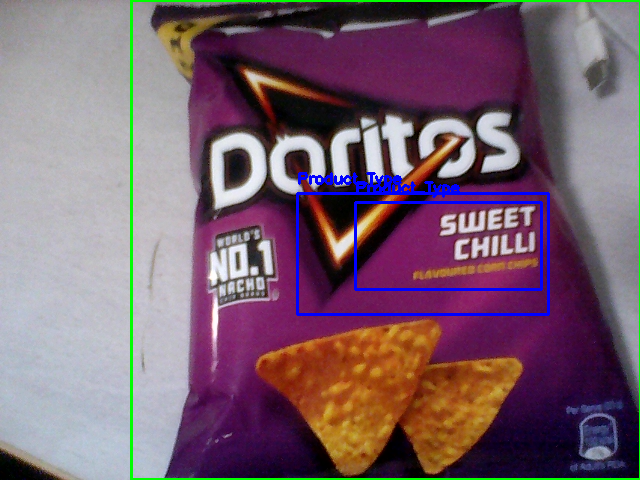

In [6]:
from ultralytics import YOLO
import cv2
from paddleocr import PaddleOCR
from google.colab.patches import cv2_imshow  # Use cv2_imshow in Colab

# Load the category detection model (first model)
category_model = YOLO('/content/category.pt')  # Replace with your model path

# Load the brand, type, and flavor detection model (second model)
brand_type_flavor_model = YOLO('/content/brand_type (1).pt')  # Replace with your model path

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Class mapping for the category model
category_class_mapping = {0: 'biscuit', 1: 'chips', 2: 'chocolate', 3: 'duo', 4: 'milk', 5: 'shampoo'}  # Adjust according to your model's classes

# Class mapping for the second model (Brandname, Product_Type, Flavour)
class_mapping = {0: 'Flavour', 1: 'Product_Type', 2: 'Brandname'}  # Adjust according to your model's classes

def extract_text_from_bbox(image, bbox):
    """Crop the region of interest (ROI) and run PaddleOCR on it."""
    x1, y1, x2, y2 = map(int, bbox)  # Convert to integer coordinates
    roi = image[y1:y2, x1:x2]  # Crop the image using the bounding box
    result = ocr.ocr(roi, cls=True)  # Perform OCR on the cropped ROI

    text_list = []

    # Check if the result contains any valid text detection
    if result and result[0]:
        for line in result[0]:
            text = line[1][0]  # Extract detected text
            text_list.append(text)

    # Return the text if found, else return 'No text detected'
    return ' '.join(text_list) if text_list else 'No text detected'

# Step 1: Run the category detection model
image_path = '/content/captured_image.png'  # Replace with your image path
image = cv2.imread(image_path)
original_image = image.copy()  # Keep a copy of the original image for displaying bounding boxes
category_results = category_model.predict(image)

# Initialize a list to store the information for each item
items_info = []

# Step 2: Iterate over detected categories and process each item
for idx, category_result in enumerate(category_results):
    for i, category_box in enumerate(category_result.boxes.xyxy):
        # Get the category class ID and name
        category_class_id = int(category_result.boxes.cls[i])
        category_name = category_class_mapping.get(category_class_id, 'Unknown')

        # Draw the category bounding box on the original image
        x1, y1, x2, y2 = map(int, category_box)
        cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box for category
        cv2.putText(original_image, category_name, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        category_roi = image[y1:y2, x1:x2]  # Region of Interest (ROI) for category

        # Run the second model (brand, type, flavor detection) within the category ROI
        btf_results = brand_type_flavor_model.predict(category_roi)

        # Initialize a dictionary to store the detected texts for this item
        item_info = {'Category': category_name}

        # Prepare a dictionary to hold lists of detected texts for each class
        detected_texts = {'Brandname': [], 'Product_Type': [], 'Flavour': []}

        # Step 3: For each bounding box detected in the second model, extract text
        for j, btf_box in enumerate(btf_results[0].boxes.xyxy):
            # Get the class ID and class name
            class_id = int(btf_results[0].boxes.cls[j])
            class_name = class_mapping.get(class_id, 'Unknown')

            # Draw the bounding box on the original image
            bx1, by1, bx2, by2 = map(int, btf_box)
            # Adjust coordinates relative to the original image
            abs_bx1, abs_by1 = x1 + bx1, y1 + by1
            abs_bx2, abs_by2 = x1 + bx2, y1 + by2

            cv2.rectangle(original_image, (abs_bx1, abs_by1), (abs_bx2, abs_by2), (255, 0, 0), 2)  # Blue box
            cv2.putText(original_image, class_name, (abs_bx1, abs_by1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Extract text from this bounding box
            text_detected = extract_text_from_bbox(category_roi, btf_box)

            # Append the detected text to the corresponding class list
            detected_texts[class_name].append(text_detected)

        # Add the detected texts to the item_info (joining all texts for each class)
        item_info['Brandname'] = ', '.join(detected_texts['Brandname']) if detected_texts['Brandname'] else 'No text detected'
        item_info['Product_Type'] = ', '.join(detected_texts['Product_Type']) if detected_texts['Product_Type'] else 'No text detected'
        item_info['Flavour'] = ', '.join(detected_texts['Flavour']) if detected_texts['Flavour'] else 'No text detected'

        # Append this item's info to the list
        items_info.append(item_info)

# Step 4: Print the information for each item
for idx, item in enumerate(items_info):
    print(f"Item {idx+1}:")
    print(f"  Category: {item['Category']}")
    print(f"  Detected Brandname(s): {item.get('Brandname', 'No text detected')}")
    print(f"  Detected Product_Type(s): {item.get('Product_Type', 'No text detected')}")
    print(f"  Detected Flavour(s): {item.get('Flavour', 'No text detected')}")
    print("")

# Step 5: Display the image with bounding boxes using cv2_imshow for Colab
cv2_imshow(original_image)